# k-Quasicenters: A Variation on k-Means Clustering Using Various Cost Metrics
### Author: Daniel Wang

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpp
import sklearn.datasets as skds

import time
import itertools

from kquasicenters import KQuasicenters # this is our custom class

## This Cell Clusters a Panoply of Datasets Using a User-Chosen Cost Metric

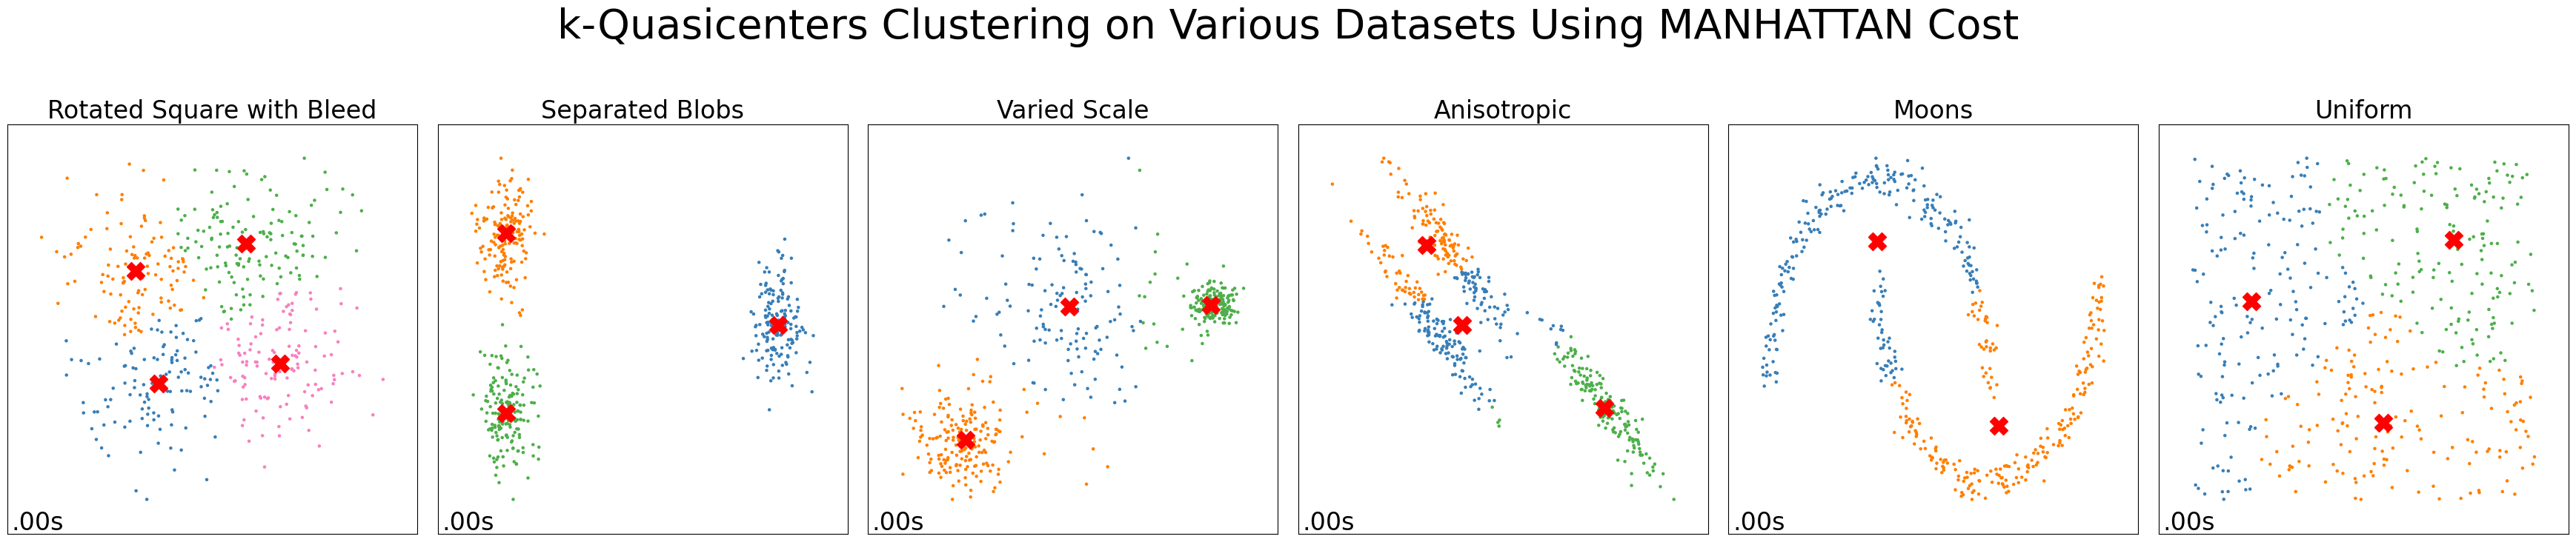

In [2]:
# NOTE: User defines the cost metric to be used
# This can be any of 'manhattan', euclidean, 'squared_euclidean', 'Lp' (where p is a positive integer), and 'euclidean^n' (where n is a positive integer).
cost_metric = 'manhattan'

# Define a random seed for reproducibility
seed = 0

# Generate synthetic datasets for clustering
n_samples = 500  # Number of data points in each dataset

# Generate the same reduce angle of rotation
centers = [[math.cos(2*math.pi/7), math.sin(2*math.pi/7)], [math.cos(2*math.pi/7+math.pi/2), math.sin(2*math.pi/7+math.pi/2)],
              [math.cos(2*math.pi/7+math.pi), math.sin(2*math.pi/7+math.pi)], [math.cos(2*math.pi/7+3*math.pi/2), math.sin(2*math.pi/7+3*math.pi/2)]]
square_bleed = skds.make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.5, random_state=seed)

# Generate isotropic Gaussian blobs that are trickily separated
centers = [[0, 0], [0, 6], [20, 3]]  # Three main clusters
separated_blobs = skds.make_blobs(n_samples=n_samples, centers=centers, random_state=seed)

# Generate Gaussian blobs with varied variances
varied_scale = skds.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)

# Generate Gaussian blobs and transform them into anisotropic clusters
X, y = skds.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_anisotropic = np.dot(X, transformation)
anisotropic = (X_anisotropic, y)

# Make two interleaving half circles
moons = skds.make_moons(n_samples=n_samples, noise=.05)

# Generate uniform random points in the 2D plane
uniform = np.random.rand(n_samples, 2), None

# Define a set of colors for visualizing clusters
colors = np.array(list(itertools.islice(itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']), 4)))

# Create a list of datasets for processing and their corresponding names for visualization
datasets = [square_bleed, separated_blobs, varied_scale, anisotropic, moons, uniform]
dataset_names = ['Rotated Square with Bleed', 'Separated Blobs', 'Varied Scale', 'Anisotropic', 'Moons', 'Uniform']

# Define the size of the figure based on the number of datasets
fig_width = len(datasets) * 6  
fig_height = 6  

# Create a new figure
plt.figure(figsize=(fig_width, fig_height))

# Variable to keep track of subplot number
plot_num = 1

# Iterate over datasets and apply k-quasicenters clustering
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset

    # Normalize dataset for easier parameter selection
    X = skpp.StandardScaler().fit_transform(X)

    # Define the number of clusters based on the dataset
    n_clusters = 3 if i_dataset in [1, 2, 3, 5] else 2 if i_dataset == 4 else 4

    # Create a KQuasicenters instance and fit the model to the data
    # NOTE: Several of the keyword arguments in KQuasicenters() and kquasicenters.fit() may go unused (depending on the choice of cost_metric)
    # However, all optional arguments are set below for the convenience and rapidity of the user. See documentation for details.
    kquasicenters = KQuasicenters(n_clusters=n_clusters, init='forgy', max_iter=400, random_state=seed, verbose=False)
    t0 = time.time()
    kquasicenters.fit(X, cost_metric=cost_metric, tolerance=1e-4, max_steps=100, descent_rate=0.2, max_descents=3)
    t1 = time.time()
    y_pred = kquasicenters.predict(X, cost_metric=cost_metric)

    # Create a subplot for this dataset
    ax = plt.subplot(1, len(datasets), plot_num)

    # Set the title of the subplot as the dataset name
    plt.title(dataset_names[i_dataset], size=24)

    # Plot the data points, colored by their cluster assignment
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=5)

    # If optimoids are available, plot them on the subplot
    if hasattr(kquasicenters, 'optimoids'):
        optimoids = kquasicenters.optimoids
        plt.scatter(optimoids[:, 0], optimoids[:, 1], s=300, c='red', zorder=10, marker='X')

    # Set the limits of the plot to slightly larger than the min and max of the data
    x_min, x_max = X[:, 0].min() - 0.1*(X[:, 0].max() - X[:, 0].min()), X[:, 0].max() + 0.1*(X[:, 0].max() - X[:, 0].min())
    y_min, y_max = X[:, 1].min() - 0.1*(X[:, 1].max() - X[:, 1].min()), X[:, 1].max() + 0.1*(X[:, 1].max() - X[:, 1].min())

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Set the aspect of the subplot to ensure it is a square
    ax.set_aspect(abs(x_max-x_min)/abs(y_max-y_min))

    # Hide the tick marks
    plt.xticks(())
    plt.yticks(())

    # Display the time taken to fit the KQuasicenters model in the bottom right of the subplot
    plt.text(.01, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=24, horizontalalignment='left')

    # Move to the next subplot
    plot_num += 1

# Add a title to the entire figure
plt.suptitle('k-Quasicenters Clustering on Various Datasets Using ' + cost_metric.upper() + ' Cost', size=40, y=1.2)

# Adjust layout for better visualization
plt.tight_layout()
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)

# Display the figure
plt.show()


## This Cell ALSO Clusters a Panoply of Datasets...<br>BUT Allows the User to Compare the Performance of Two Different Cost Metrics

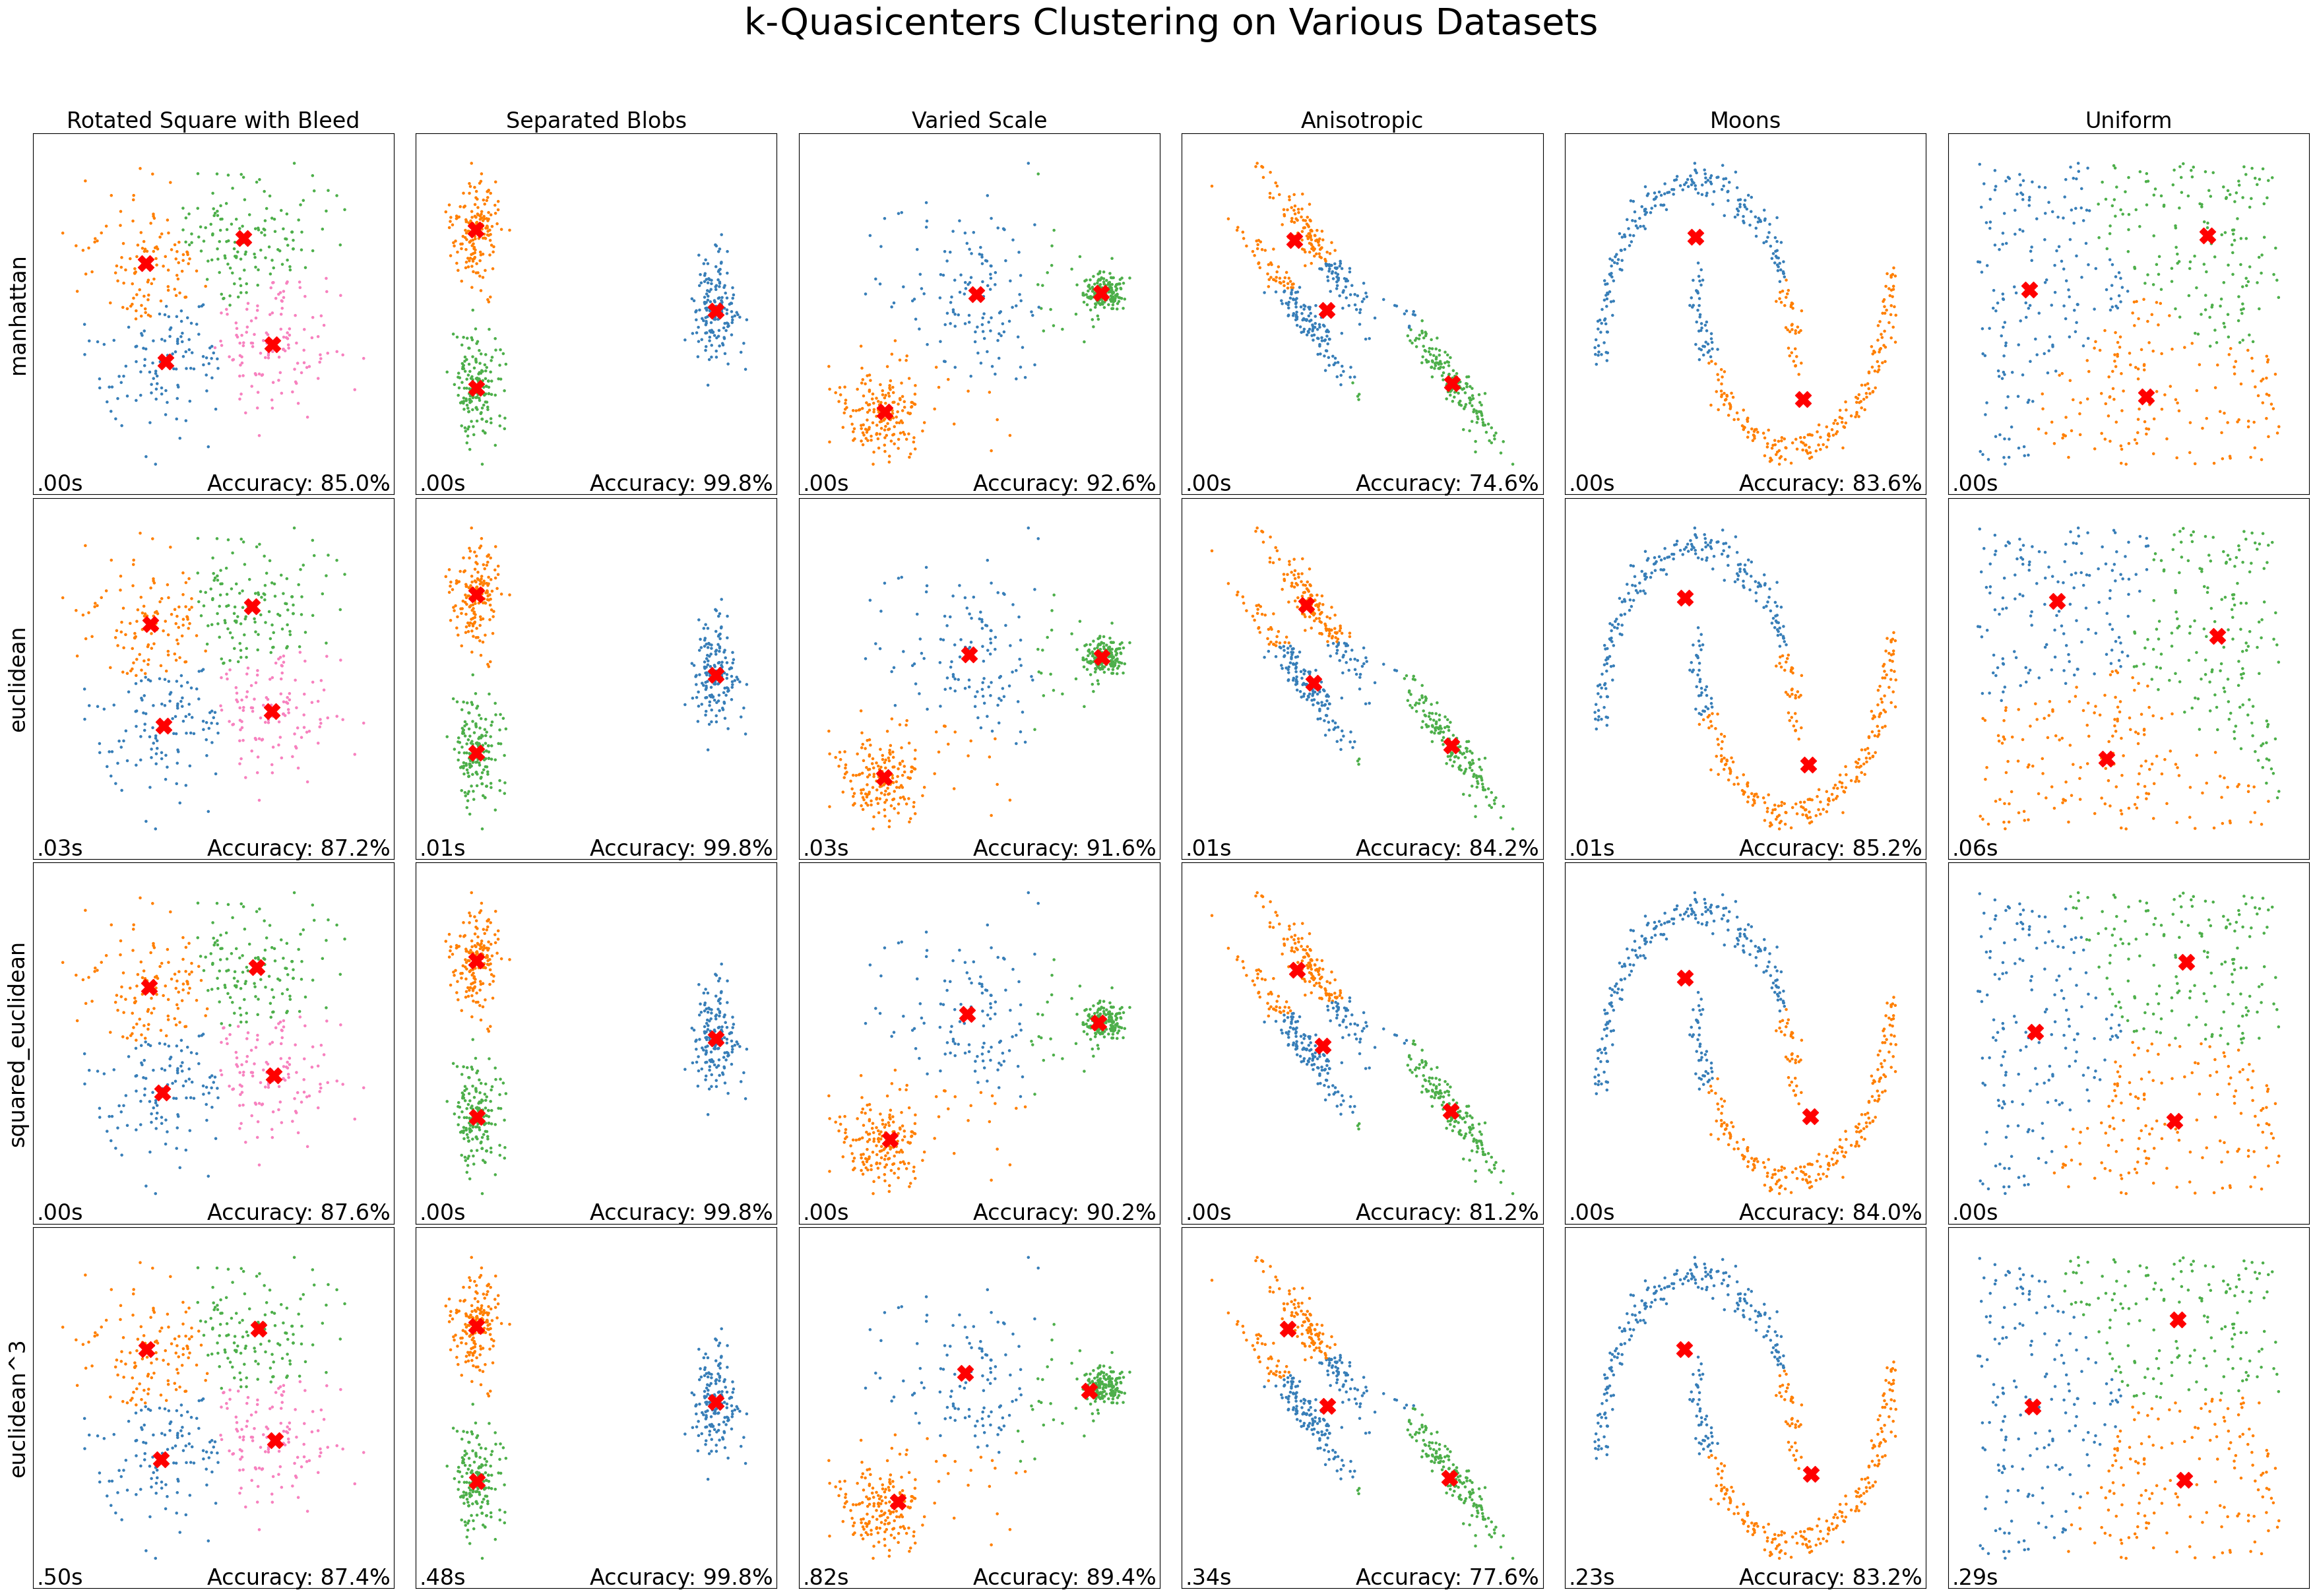

In [3]:
# Define your cost metrics
cost_metrics = ['manhattan', 'euclidean', 'squared_euclidean', 'euclidean^3']

# Adjust the figsize parameter based on the number of datasets
fig_width = len(datasets) * 6  # Increase width for larger subplots
fig_height = len(cost_metrics) * 6  # Increase height for larger subplots

fig, axes = plt.subplots(len(cost_metrics), len(datasets), figsize=(fig_width, fig_height), squeeze=False)

for i, cost_metric in enumerate(cost_metrics):
    for j, dataset in enumerate(datasets):
        X, y = dataset
        # Normalize dataset for easier parameter selection
        X = skpp.StandardScaler().fit_transform(X)

        n_clusters = 3 if j in [1, 2, 3, 5] else 4 if j==0 else 2

        # Create and fit the KQuasicenters model
        kquasicenters = KQuasicenters(n_clusters=n_clusters, init='forgy', max_iter=400, random_state=seed, verbose=False)
        t0 = time.time()
        kquasicenters.fit(X, cost_metric=cost_metric, tolerance=1e-4, max_steps=100, descent_rate=0.2, max_descents=3)
        t1 = time.time()
        y_pred = kquasicenters.predict(X, cost_metric=cost_metric)

        if y is not None:
            # Calculate the accuracy based on the true labels
            accuracy = kquasicenters.evaluate(y)
        else:
            accuracy = None

        # Create a subplot for this dataset
        ax = axes[i, j]

        # Plot the data points, colored by their cluster assignment
        ax.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=5)

        # If optimoids are available, plot them on the subplot
        if hasattr(kquasicenters, 'optimoids'):
            optimoids = kquasicenters.optimoids
            ax.scatter(optimoids[:, 0], optimoids[:, 1], s=300, c='red', zorder=10, marker='X')

        # Set the limits of the plot to slightly larger than the min and max of the data
        x_min, x_max = X[:, 0].min() - 0.1*(X[:, 0].max() - X[:, 0].min()), X[:, 0].max() + 0.1*(X[:, 0].max() - X[:, 0].min())
        y_min, y_max = X[:, 1].min() - 0.1*(X[:, 1].max() - X[:, 1].min()), X[:, 1].max() + 0.1*(X[:, 1].max() - X[:, 1].min())

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Set the aspect of the subplot to ensure it is a square
        ax.set_aspect(abs(x_max-x_min)/abs(y_max-y_min))

        # Hide the tick marks
        ax.set_xticks(())
        ax.set_yticks(())

        # Display the time taken to fit the KQuasicenters model in the bottom left of the subplot
        ax.text(.01, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=ax.transAxes, size=24, horizontalalignment='left')

        # Display the accuracy in the bottom right of the subplot
        if accuracy is not None:
            ax.text(.99, .01, ('Accuracy: %.1f%%' % (accuracy * 100)).lstrip('0'), transform=ax.transAxes, size=24, horizontalalignment='right')

        # If this is the first row, set the title as the dataset name
        if i == 0:
            ax.set_title(dataset_names[j], size=24)

        # If this is the first column, set the ylabel as the cost metric (rotated 90 degrees counterclockwise)
        if j == 0:
            ax.set_ylabel(cost_metric, size=24, rotation='vertical')

plt.suptitle('k-Quasicenters Clustering on Various Datasets', size=40, y=1.0)
plt.tight_layout()
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.92, wspace=0.05, hspace=0.01)
plt.show()

